# About 

When training CNNs, we typically resize our input images to some standard size before passing them to the model. For example, if the original images are `600 x 400` we might resize them to a resolution like `248 x 248` or `512 x 512` as a preprocessing step.

But this resizing results in information loss, and every time we resize images with `opencv`, we rely on some interpolation algorithm to decrease this resize-loss as much as possible. Instead of using `cv2.INTER_LINEAR` or `cv2.INTER_AREA`, why not train our own 'algorithm' to resize the images? The simplest example would be to take a `1024 x 1024` image and convolve it to size `512 x 512` before giving it to the CNN backbone. This way, the model learns how to best resize the images alongside the main training task. 

This was done succesfully [here](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/226557) and [here](https://www.kaggle.com/c/understanding_cloud_organization/discussion/118255) - two competitions in which the native image resolutions where > `1400 x 1400`. Seeing as we have fairly large 'images' for this competition, let's try it here. Instead of using either of the two above approaches, I want to try to implement the approach from [this paper](https://arxiv.org/abs/2103.09950) in which the proposed 'learned image resizer' looks like:

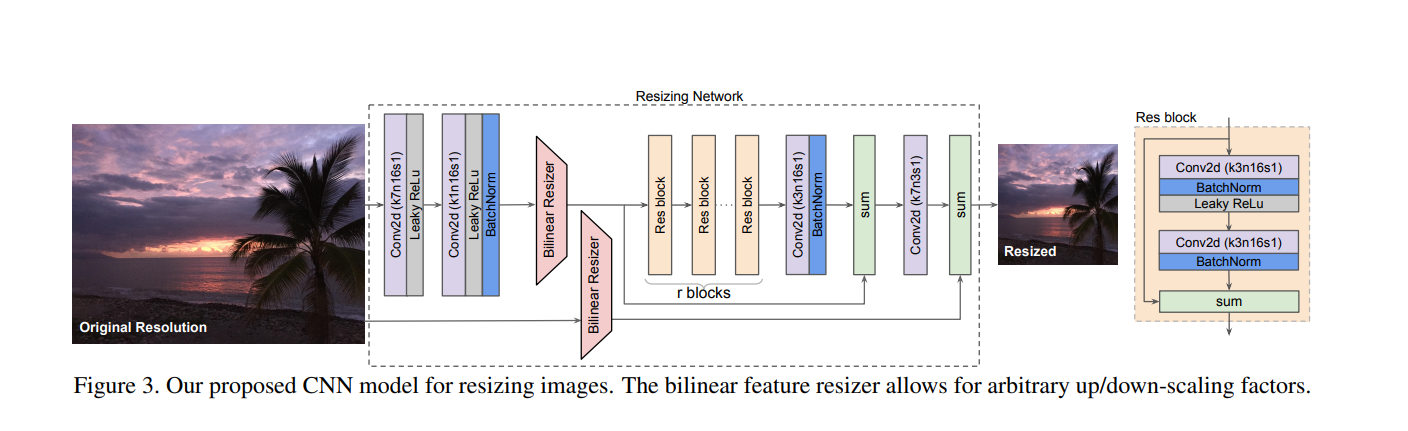

In this commit, we will feed the learned image resizer original resolution images for it to resize to `256 x 256`. Note that I am not 100% sure I coded all this correctly, so if you see anything suspicious, please let me know. While I opted for the approach taken in the paper, the previously linked approaches seem fruitful as well and require less training time. 

Code template is taken from the one and only [yasufuminakama](https://www.kaggle.com/yasufuminakama).

# Data Loading

In [ ]:
! pip install -q pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import gc
import torch
print(torch.__version__)

In [ ]:
train = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
test = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "../input/seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "../input/seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

# Directory settings

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=100
    num_workers=4
    model_name='efficientnet_b0'  #'efficientnet_b0', 'vit_base_patch16_224', 'tf_efficientnet_b4_ns'
    input_size=512   #512, 768, 1028, 'original'
    output_size=256 
    scheduler='CosineAnnealingLR' #'ReduceLROnPlateau', 'CosineAnnealingLR'
    epochs=18
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-8 # ReduceLROnPlateau
    T_max=15 # CosineAnnealingLR
    lr=1e-5
    min_lr=1e-7
    batch_size=32
    optimizer='adamw'   #adamw', 'adam' 
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=29
    target_size=1
    target_col='target'
    n_fold=5
    trn_folds=[0]
    train=True
    mode='spatial_3'   #'channel_3', 'channel_6', 'spatial_3', spatial_6'
    aug_mode='mixup'   #'mixup', 'fmix'
    warmup_epochs=2
    multiplier=10
    epoch_no_aug=0
    
if CFG.debug:
    CFG.epochs=3
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)   

# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/image-fmix/FMix-master')
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
from fmix import sample_mask

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
from warmup_scheduler import GradualWarmupScheduler
from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [ ]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

# Dataset

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, mode=CFG.mode, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        label = self.labels[idx]
        image = np.load(file_path)
        
        if self.mode in ['spatial_3', 'channel_3']:
            image = image[::2]
            image = image.astype(np.float32)
        else:
            image = image.astype(np.float32)
        if self.mode in ['spatial_3', 'spatial_6']: 
            image = np.vstack(image).transpose((1, 0))
        elif self.mode in ['channel_3', 'channel_6']:
            image = np.transpose(image, (1,2,0))
            
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
            
        label = torch.tensor(label).float()
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, df, mode=CFG.mode, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.load(file_path)
        if self.mode in ['spatial_3', 'channel_3']:
            image = image[::2].astype(np.float32)
        else:
            image = image.astype(np.float32)
        if self.mode in ['spatial_3', 'spatial_6']:
            image = np.vstack(image).transpose((1, 0))
        elif self.mode in ['channel_3', 'channel_6']:
            image = np.transpose(image, (1,2,0))
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        return image
    
def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

# Transforms

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    if data == 'train':
        if type(CFG.input_size) == int:
            return A.Compose([
                   A.Resize(CFG.input_size, CFG.input_size),
                   A.HorizontalFlip(p=.5),
                   A.VerticalFlip(p=.5),
                   A.ShiftScaleRotate(rotate_limit=0, p=.25),
                   A.MotionBlur(p=.2),
                   A.IAASharpen(p=.25),
                   ToTensorV2(),
            ])
        else:
            return A.Compose([
                   A.HorizontalFlip(p=.5),
                   A.VerticalFlip(p=.5),
                   A.ShiftScaleRotate(rotate_limit=0, p=.25),
                   A.MotionBlur(p=.2),
                   A.IAASharpen(p=.25),
                   ToTensorV2(),
            ])
            
    elif data == 'valid':
        if type(CFG.input_size) == int:
            return A.Compose([
                   A.Resize(CFG.input_size, CFG.input_size),
                   ToTensorV2(),
            ])
        else:
            return A.Compose([
                   ToTensorV2(),
            ])

In [ ]:
# https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
def mixup_data(x, y, alpha=1, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = (lam**.5) * x + ((1 - lam)**.5) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def fmix_data(data, targets, alpha=1.0, 
              decay_power=3.0,
              max_soft=0.0,
              shape=(CFG.input_size, CFG.input_size),):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft)
    indices = torch.randperm(data.size(0)).cuda()
    shuffled_data = data[indices]
    
    targets_a = targets
    targets_b = targets[indices]
    x1 = torch.from_numpy(mask).float()*data
    x2 = torch.from_numpy(1-mask).float()*shuffled_data
    return (x1+x2), targets_a, targets_b, lam

def aug_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.n = 16
        self.slope = .1
        self.r = 1
        
        if self.cfg.mode in ['spatial_3', 'spatial_6']: 
            self.cnn = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        elif self.cfg.mode == 'channel_3':
            self.cnn = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        elif self.cfg.mode == 'channel_6':
            self.cnn = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=6)
        if hasattr(self.cnn, "fc"):
            nb_ft = self.cnn.fc.in_features
            self.cnn.fc = nn.Identity()
        elif hasattr(self.cnn, "_fc"):
            nb_ft = self.cnn._fc.in_features
            self.cnn._fc = nn.Identity()
        elif hasattr(self.cnn, "classifier"):
            nb_ft = self.cnn.classifier.in_features
            self.cnn.classifier = nn.Identity()
        elif hasattr(self.cnn, "last_linear"):
            nb_ft = self.cnn.last_linear.in_features
            self.cnn.last_linear = nn.Identity()
        elif hasattr(self.cnn, "head"):
            nb_ft = self.cnn.head.in_features
            self.cnn.head = nn.Identity()
        
        self.block1 = nn.Sequential(
                nn.Conv2d(1, self.n, kernel_size=(7, 7), stride=(1,1), padding=(1, 1), bias=False),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.Conv2d(self.n, self.n, kernel_size=(1, 1), stride=(1,1), padding=(1, 1), bias=False),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.BatchNorm2d(self.n))
        self.block2 = nn.Sequential(
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n))
        self.block3 = nn.Sequential(
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n))
        self.block4 = nn.Sequential(
                nn.Conv2d(self.n, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False))
        self.fc = nn.Linear(nb_ft, self.cfg.target_size)

    def forward(self, x):
        res1 = F.interpolate(x, size=(self.cfg.output_size, self.cfg.output_size), mode='bilinear')
        x = self.block1(x)
        res2 = F.interpolate(x, size=(self.cfg.output_size, self.cfg.output_size), mode='bilinear')

        x = self.block2(res2)
        x += res2
        if self.r > 1:
            for _ in range(self.r):
                res2 = x
                x = self.block2(x)
                x += res2
 
        x = self.block3(x)
        x += res2
        
        x = self.block4(x)
        x += res1
        
        x = self.cnn(x)
        x = self.fc(x)
        return x

# Learning Rate

In [ ]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, mode):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        if mode == 'mixup':
            images, targets_a, targets_b, lam = mixup_data(images, labels.view(-1, 1), use_cuda=True)
            images = images.to(device)
            targets_a = targets_a.to(device)
            targets_b = targets_b.to(device)
            y_preds = model(images)
            loss = aug_criterion(criterion, y_preds, targets_a, targets_b, lam)
            
        elif mode == 'fmix':
            images, targets_a, targets_b, lam = fmix_data(images, labels.view(-1, 1))
            images = images.to(device)
            targets_a = targets_a.to(device)
            targets_b = targets_b.to(device)
            y_preds = model(images)
            loss = aug_criterion(criterion, y_preds, targets_a, targets_b, lam)

        else:
            images = images.to(device)
            labels = labels.to(device)
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
            
        batch_size = labels.size(0)
        
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def flip_inference(models, test_loader, device):
    preds = []
    for i, fold in enumerate(CFG.trn_folds):
        model = models[i]
        probs = []
        for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(device)
            with torch.no_grad():
                y_preds1 = model(images)
                y_preds2 = model(images.flip(-1))
                y_preds3 = model(images.flip(-2))
                y_preds4 = model(images.flip(-1).flip(-2))
            y_preds = (y_preds1.sigmoid().to('cpu').numpy() + y_preds2.sigmoid().to('cpu').numpy() + y_preds3.sigmoid().to('cpu').numpy() + y_preds4.sigmoid().to('cpu').numpy()) / 4
            probs.append(y_preds[:, 0])
        preds.append(np.concatenate(probs))
    return preds

def get_models(CFG, mode='loss'):
    models = []
    for fold in CFG.trn_folds:
        model = CustomModel(cfg=CFG, pretrained=False)
        path = OUTPUT_DIR + f'{CFG.model_name}_fold{fold}_best_{mode}.pth'
        model.load_state_dict(torch.load(path)['model'])
        model.eval()
        model.to(device)
        models.append(model)
    return models

# Train Loop

In [ ]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True,
                              drop_last=True, worker_init_fn=worker_init_fn)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # ====================================================
    # optimizer
    # ====================================================
    def get_optimizer(lr=CFG.lr):
        if CFG.optimizer == 'adam':
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay, amsgrad=False)
        elif CFG.optimizer == 'adamw':
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        return optimizer
    
    # ====================================================
    # criterion
    # ====================================================
    def get_criterion():
        criterion = nn.BCEWithLogitsLoss()
        return criterion
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        if CFG.warmup_epochs > 0:
            scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=CFG.multiplier,
                                                 total_epoch=CFG.warmup_epochs, 
                                                 after_scheduler=scheduler)
        return scheduler 
    
    # ====================================================
    # training loop
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)
    
    optimizer = get_optimizer()
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    best_score = 0.
    best_loss = np.inf

    for epoch in range(CFG.epochs + CFG.epoch_no_aug):
        start_time = time.time()
        
        # train
        if epoch < CFG.epochs:
            avg_loss = train_fn(train_loader, model, criterion, optimizer,
                                 epoch, scheduler,
                                 device,
                                 mode=CFG.aug_mode)
        else:
            optimizer = get_optimizer(lr=1e-6)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, mode='none')

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
    
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, GradualWarmupSchedulerV2):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()

# Inference

In [ ]:
models = get_models(CFG, mode='loss')
models_ = get_models(CFG, mode='score')
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size*2, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
fold_preds = flip_inference(models, test_loader, device)
fold_preds_ = flip_inference(models_, test_loader, device)
preds = np.mean(fold_preds, axis=0)
preds_ = np.mean(fold_preds_, axis=0)

In [ ]:
test = test[['id', 'target']]
test[CFG.target_col] = (preds + preds_) / 2
test.to_csv(OUTPUT_DIR+'submission.csv', index=False)
display(test)

In [ ]:
test[CFG.target_col] = (preds*0.4 + preds_*0.6)
test.to_csv(OUTPUT_DIR+'submission0.csv', index=False)

In [ ]:
test[CFG.target_col] = (preds*0.3 + preds_*0.7)
test.to_csv(OUTPUT_DIR+'submission1.csv', index=False)

In [ ]:
test[CFG.target_col] = (preds*0.6 + preds_*0.4)
test.to_csv(OUTPUT_DIR+'submission2.csv', index=False)

In [ ]:
test[CFG.target_col] = (preds*0.7 + preds_*0.3)
test.to_csv(OUTPUT_DIR+'submission3.csv', index=False)